In [231]:
import skimage as ski
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

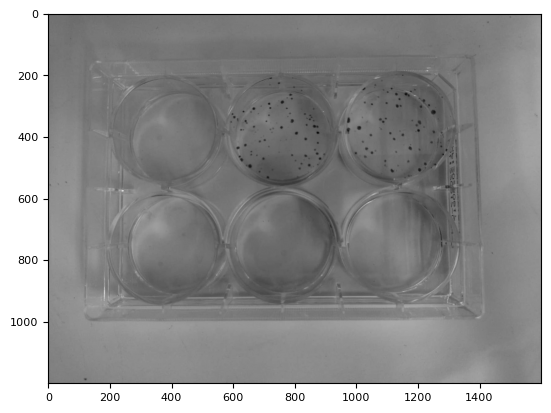

In [232]:
image = cv.imread("/home/frederico/dados/clonogenic/WhatsApp Image 2023-10-02 at 10.34.41.jpeg")
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(image_gray, cmap="gray")
plt.show()

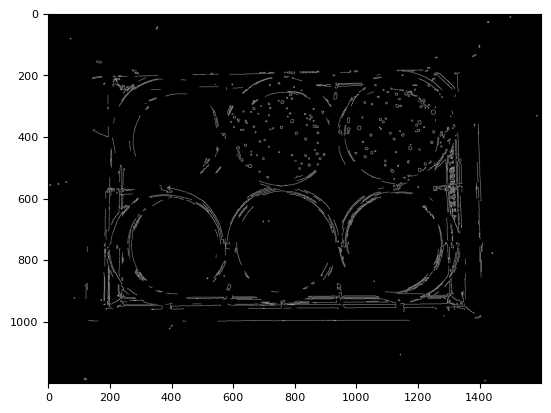

In [ ]:
edges = ski.feature.canny(image_gray, sigma=0)
plt.imshow(edges, cmap="gray")
plt.show()

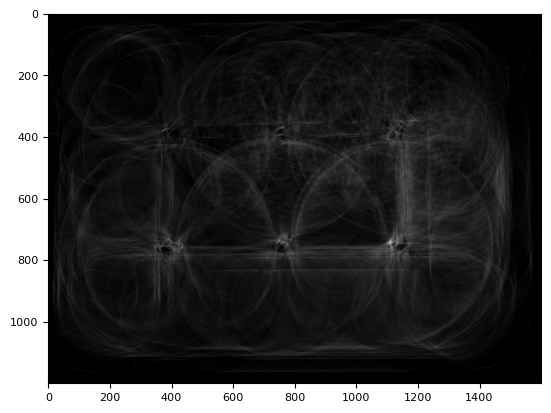

In [234]:
radius = [165]
hough_res = ski.transform.hough_circle(edges, radius)

plt.imshow(hough_res[0], cmap="gray")
plt.show()

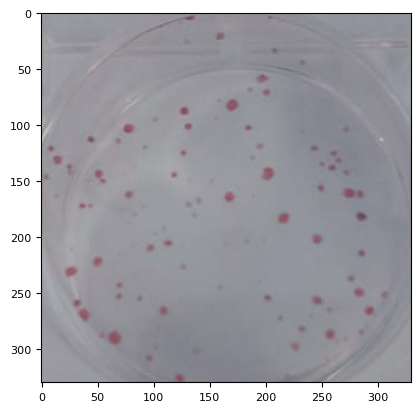

5


In [235]:
accum, cx, cy, radii = ski.transform.hough_circle_peaks(hough_res, radius, min_xdistance=radius[0], min_ydistance=radius[0])

x, y = image.shape[1], image.shape[0]

circles = [{"cx": x[0], "cy": x[1], "radii": x[2]} for x in zip(cx, cy, radii)]
circles = list(filter(lambda c: c["cx"] - c["radii"] > 0 and c["cx"] + c["radii"] < x and c["cy"] - c["radii"] > 0 and c["cy"] + c["radii"] < y, circles))

x_plots = 3 if len(circles) > 3 else len(circles)
y_plots = len(circles) // 3 + (1 if len(circles) % 3 > 0 else 0)

for circle in circles:
    plt.imshow(image[circle["cy"] - circle["radii"]:circle["cy"] + circle["radii"], circle["cx"] - circle["radii"]:circle["cx"] + circle["radii"]], cmap="gray")
plt.show()
print(len(circles))

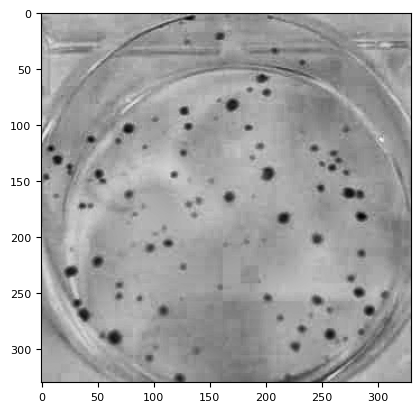

In [236]:
circle = circles[4]
well_image = image[circle["cy"] - circle["radii"]:circle["cy"] + circle["radii"], circle["cx"] - circle["radii"]:circle["cx"] + circle["radii"]]

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
cl1 = clahe.apply(well_image[:, :, 2])

plt.imshow(cl1, cmap="gray")
plt.show()

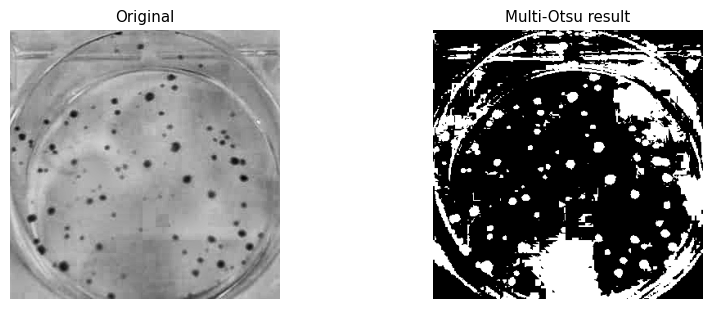

In [237]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = cl1

# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes = 2)

# Using the threshold values, we generate the three regions.
regions = cv.bitwise_not(np.digitize(image, bins=thresholds))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the Multi Otsu result.
ax[1].imshow(regions, cmap='gray')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')

plt.subplots_adjust()

plt.show()

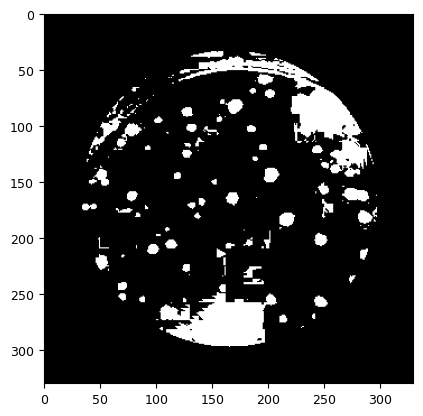

In [238]:
center = well_image.shape[0] // 2, well_image.shape[1] // 2

#paint black everythoing outside a circle inscribed in the image
mask = np.zeros(well_image.shape[:2], dtype="uint8")
cv.circle(mask, center, center[0] - round(0.2 * center[0]), (255, 255, 255), -1)
masked = cv.bitwise_and(regions, regions, mask=mask)

masked = masked == -1
masked = masked.astype("uint8")

plt.imshow(masked, cmap="gray")
plt.show()

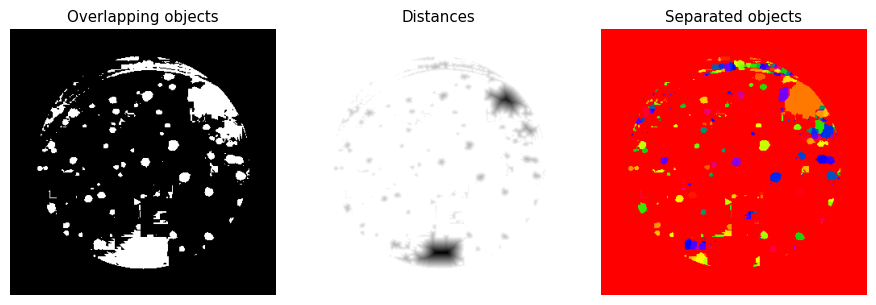

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
image = masked

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap="prism")
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

/tmp/ipykernel_18410/3995085236.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('prism', np.max(labels) + 1 if np.max(labels) > 0 else 2)


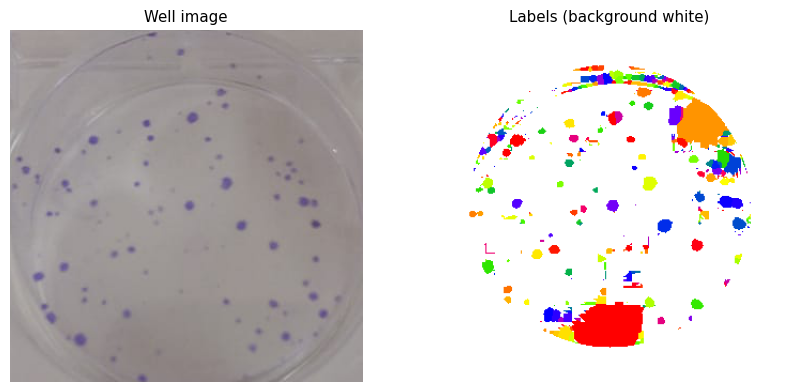

In [240]:
cmap = plt.cm.get_cmap('prism', np.max(labels) + 1 if np.max(labels) > 0 else 2)
norm = np.max(labels) if np.max(labels) > 0 else 1

# map labels to RGBA and force background (label 0) to white
colored = cmap(labels / norm)
colored[labels == 0] = (1.0, 1.0, 1.0, 1.0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(well_image[..., ::-1])  # convert BGR->RGB for correct display
ax[0].set_title('Well image')
ax[0].axis('off')

ax[1].imshow(colored)
ax[1].set_title('Labels (background white)')
ax[1].axis('off')

plt.show()


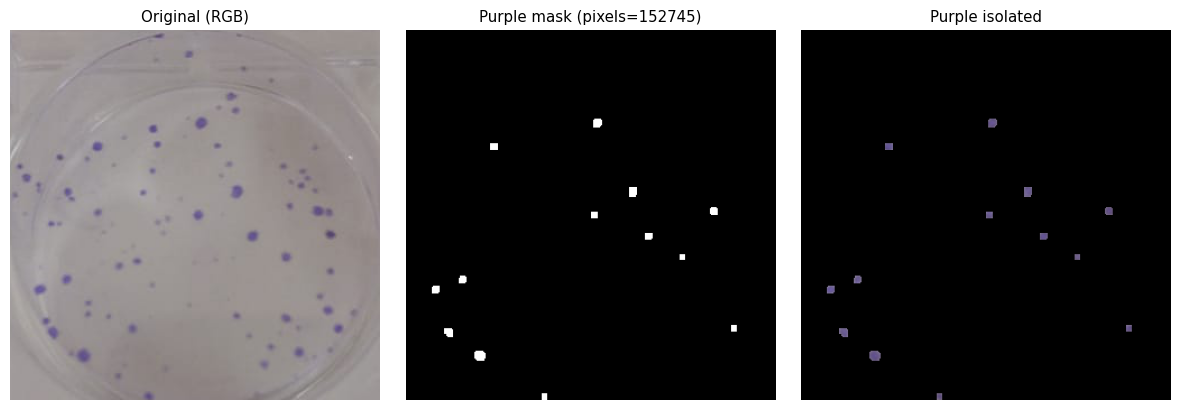

In [241]:
# define sane HSV bounds for purple/magenta and isolate regions
lower_purple = np.array([125, 50, 50], dtype=np.uint8)   # H,S,V (H: 0-179)
upper_purple = np.array([155, 255, 255], dtype=np.uint8)

hsv = cv.cvtColor(well_image, cv.COLOR_BGR2HSV)  # safe to recompute / overwrite

mask = cv.inRange(hsv, lower_purple, upper_purple)

# clean mask (reuse existing `kernel`)
mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

# extract purple pixels
purple_only = cv.bitwise_and(well_image, well_image, mask=mask)

# display results (convert BGR->RGB for correct colors in matplotlib)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(well_image[..., ::-1])
ax[0].set_title('Original (RGB)')
ax[0].axis('off')

ax[1].imshow(mask, cmap='gray')
ax[1].set_title(f'Purple mask (pixels={mask.sum()})')
ax[1].axis('off')

ax[2].imshow(purple_only[..., ::-1])
ax[2].set_title('Purple isolated')
ax[2].axis('off')

plt.tight_layout()
plt.show()


In [262]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

# Convert to float: Important for subtraction later which won't work with uint8
image = -cl1
image = gaussian_filter(image, 0)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

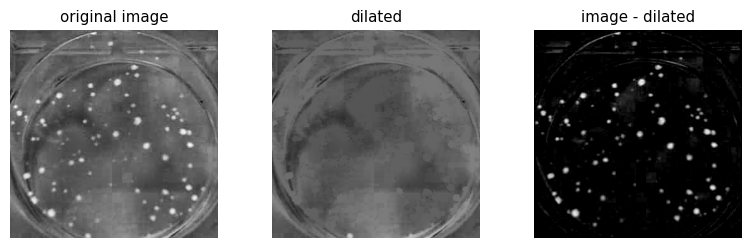

In [263]:
fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=1, ncols=3, figsize=(8, 2.5), sharex=True, sharey=True
)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

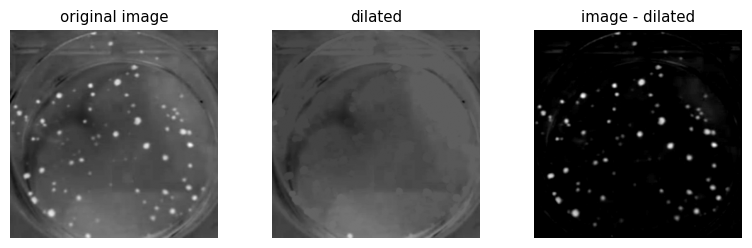

In [257]:
# Convert to float: Important for subtraction later which won't work with uint8
image = -well_image[..., 2]
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

fig, (ax0, ax1, ax2) = plt.subplots(
    nrows=1, ncols=3, figsize=(8, 2.5), sharex=True, sharey=True
)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()